# 1-4: LSTM 모델

## 학습 목표
- 1-S4에서 배운 LSTM을 실제 FDS 데이터에 적용
- 시퀀스 데이터 생성 (슬라이딩 윈도우)
- LSTM 모델 학습 및 Early Stopping
- XGBoost와 성능 비교

## 이 노트북에서 할 것
```
train.csv → 시퀀스 생성 → LSTM 학습 → 모델 저장 (.pt)
                       ↘ 성능 평가 (AUC)
                       ↘ XGBoost와 비교
```

## 🔑 핵심 개념 복습 (1-S4에서 배운 것)

### XGBoost vs LSTM
| 모델 | 입력 | 장점 |
|------|------|------|
| XGBoost | 단일 거래 (1행) | 정형 피처에 강함 |
| LSTM | 거래 시퀀스 (N행) | 시간 패턴 학습 |

### 왜 LSTM을 추가하는가?
```
사기 패턴 예시:
거래1: 소액 (1만원) → 정상처럼 보임
거래2: 소액 (2만원) → 정상처럼 보임  
거래3: 고액 (100만원) → 🚨 의심!

XGBoost: 거래3만 보면 "그냥 큰 거래네" 
LSTM: "소액→소액→고액 패턴이다!" → 사기 탐지
```

In [1]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import joblib

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로
DATA_DIR = Path('../../data')
DATA_PROCESSED = DATA_DIR / 'processed'
MODELS_DIR = Path('../../models')
MODELS_DIR.mkdir(exist_ok=True)

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n패키지 로드 완료!")

Device: cuda
GPU: NVIDIA GeForce RTX 2070 SUPER

패키지 로드 완료!


---

## 섹션 1: 데이터 로드

In [2]:
# 원본 데이터 로드 (시퀀스 생성에 card1, TransactionDT 필요)
train_df = pd.read_csv(DATA_PROCESSED / 'train.csv')
test_df = pd.read_csv(DATA_PROCESSED / 'test.csv')

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"\n컬럼 예시: {train_df.columns[:10].tolist()}")

Train: (472432, 434)
Test: (118108, 434)

컬럼 예시: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5']


In [3]:
# 사기 비율 확인
print("Train 사기 비율:")
print(train_df['isFraud'].value_counts(normalize=True))

Train 사기 비율:
isFraud
0    0.964865
1    0.035135
Name: proportion, dtype: float64


---

## 섹션 2: 시퀀스 데이터 생성 ⭐

### 시퀀스 데이터란?

XGBoost는 각 거래를 **개별적으로** 봅니다:
```
거래1 → [피처1, 피처2, ...] → 예측
거래2 → [피처1, 피처2, ...] → 예측
거래3 → [피처1, 피처2, ...] → 예측
```

LSTM은 **이전 거래들을 함께** 봅니다:
```
거래1, 거래2, 거래3 → [[피처들], [피처들], [피처들]] → 예측
```

### 슬라이딩 윈도우
```
원본 거래:  [1] [2] [3] [4] [5] [6] [7] ...
                    ↓
시퀀스 1:   [1] [2] [3] → 4의 라벨 예측
시퀀스 2:       [2] [3] [4] → 5의 라벨 예측
시퀀스 3:           [3] [4] [5] → 6의 라벨 예측
```

### 왜 card1별로 그룹화?
```
card1 = 카드 번호 (사용자 식별)

같은 카드의 거래들만 시퀀스로 묶어야 의미있음!
다른 사람 거래를 섞으면 패턴이 없음
```

In [4]:
# 예제: 시퀀스 생성 함수
def create_sequences(df: pd.DataFrame, features: list, seq_len: int = 10):
    """
    사용자(card1)별 시퀀스 생성
    
    Parameters:
    -----------
    df : DataFrame - 원본 데이터
    features : list - 시퀀스에 포함할 피처 이름들
    seq_len : int - 시퀀스 길이 (이전 몇 개 거래를 볼지)
    
    Returns:
    --------
    X : np.array - (샘플수, seq_len, 피처수)
    y : np.array - (샘플수,)
    """
    sequences = []
    labels = []
    
    # card1(사용자)별로 그룹화
    for card1, group in df.groupby('card1'):
        # 시간순 정렬 (중요!)
        group = group.sort_values('TransactionDT')
        
        # 해당 사용자의 거래가 seq_len보다 적으면 스킵
        if len(group) <= seq_len:
            continue
        
        # 피처 값 추출
        values = group[features].values  # (거래수, 피처수)
        targets = group['isFraud'].values  # (거래수,)
        
        # 슬라이딩 윈도우
        for i in range(seq_len, len(group)):
            # 이전 seq_len개 거래
            seq = values[i-seq_len:i]  # (seq_len, 피처수)
            sequences.append(seq)
            
            # 현재 거래의 라벨 (예측 대상)
            labels.append(targets[i])
    
    return np.array(sequences), np.array(labels)

print("create_sequences 함수 정의 완료!")

create_sequences 함수 정의 완료!


In [5]:
# 📊 피처 선택 (V1-V20 전체 + C + D + 시계열 = 33개)
# 
# 💡 V컬럼 (V1~V339): Vesta의 PCA 기반 피처
# 💡 C컬럼: 카운트 관련 피처
# 💡 D컬럼: 시간 차이 관련 피처

# 1. V컬럼: V1~V20 (논문 표준)
v_features = [f'V{i}' for i in range(1, 21)]  # V1~V20 (20개)
print(f"V 피처: {len(v_features)}개 (V1~V20)")

# 2. C컬럼: 결측 없는 완벽한 피처
c_features = ['C1', 'C4', 'C5', 'C8', 'C10', 'C11', 'C13', 'C14']  # 8개
print(f"C 피처: {len(c_features)}개")

# 3. D컬럼: D2, D3 (XGB importance 높음)
d_features = ['D2', 'D3']  # 2개
print(f"D 피처: {len(d_features)}개")

# 4. 시계열 피처 준비
def prepare_seq_features(df: pd.DataFrame) -> pd.DataFrame:
    """시퀀스용 피처 준비"""
    df = df.copy()
    
    # 시간 피처
    if 'hour' not in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24
    if 'dayofweek' not in df.columns:
        df['dayofweek'] = (df['TransactionDT'] // 86400) % 7
    
    # 금액 로그 변환
    if 'amt_log' not in df.columns:
        df['amt_log'] = np.log1p(df['TransactionAmt'])
    
    return df

train_df = prepare_seq_features(train_df)
test_df = prepare_seq_features(test_df)

time_features = ['amt_log', 'hour', 'dayofweek']  # 3개
print(f"시계열 피처: {len(time_features)}개")

# 5. 전체 시퀀스 피처
SEQ_FEATURES = v_features + c_features + d_features + time_features
print(f"\n📊 총 시퀀스 피처: {len(SEQ_FEATURES)}개")
print(f"   V 피처: {len(v_features)}개 (V1~V20)")
print(f"   C 피처: {len(c_features)}개")  
print(f"   D 피처: {len(d_features)}개")
print(f"   시계열: {len(time_features)}개")

V 피처: 20개 (V1~V20)
C 피처: 8개
D 피처: 2개
시계열 피처: 3개

📊 총 시퀀스 피처: 33개
   V 피처: 20개 (V1~V20)
   C 피처: 8개
   D 피처: 2개
   시계열: 3개


In [6]:
%%time
# 시퀀스 생성 (시간이 좀 걸립니다)
SEQ_LEN = 10  # 이전 10개 거래를 봄
# SEQ_FEATURES는 Cell 7에서 정의됨 (33개 피처)

print(f"시퀀스 생성 중... (seq_len={SEQ_LEN})")
print(f"피처 수: {len(SEQ_FEATURES)}개")
print(f"피처 예시: {SEQ_FEATURES[:5]}...")

X_train_seq, y_train_seq = create_sequences(train_df, SEQ_FEATURES, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(test_df, SEQ_FEATURES, SEQ_LEN)

print(f"\nTrain 시퀀스: {X_train_seq.shape}")  # (샘플, 10, 33)
print(f"Test 시퀀스: {X_test_seq.shape}")
print(f"\nTrain 사기 비율: {y_train_seq.mean():.4f}")
print(f"Test 사기 비율: {y_test_seq.mean():.4f}")

시퀀스 생성 중... (seq_len=10)
피처 수: 33개
피처 예시: ['V1', 'V2', 'V3', 'V4', 'V5']...

Train 시퀀스: (407847, 10, 33)
Test 시퀀스: (88837, 10, 33)

Train 사기 비율: 0.0367
Test 사기 비율: 0.0360
CPU times: total: 9.28 s
Wall time: 9.29 s


In [7]:
# 시퀀스 예시 확인
print("시퀀스 예시 (첫 번째 샘플):")
print(f"Shape: {X_train_seq[0].shape}")
print(f"\n거래 1~10의 피처 (amt_log, hour, dayofweek):")
print(pd.DataFrame(X_train_seq[0], columns=SEQ_FEATURES))
print(f"\n→ 이 시퀀스의 라벨 (다음 거래가 사기인지): {y_train_seq[0]}")

시퀀스 예시 (첫 번째 샘플):
Shape: (10, 33)

거래 1~10의 피처 (amt_log, hour, dayofweek):
    V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...   C8  C10  C11   C13  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  0.0  1.0   1.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  2.0  11.0   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  1.0  1.0  1.0   1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  1.0  1.0  1.0   0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  1.0  1.0  1.0   1.0   
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...  0.0  0.0  1.0   2.0   
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  2.0  13.0   
7  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  0.0  ...  0.0  0.0  1.0   3.0   
8  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...  0.0  0.0  1.0   4.0   
9  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...  0.0  0.0  1.0   5.0   

   C14    D2    D3   amt_log  hou

### 🔍 데이터 품질 점검: 결측률 분석

AUC가 기대보다 낮다면, 데이터 품질을 확인해봐야 합니다.
피처별 결측률을 분석하여 문제가 있는 피처를 찾아봅시다.

In [78]:
# 📊 피처별 결측률 분석
print("="*60)
print("📊 SEQ_FEATURES 결측률 분석")
print("="*60)

missing_stats = []
for col in SEQ_FEATURES:
    miss_count = train_df[col].isna().sum()
    miss_rate = train_df[col].isna().mean() * 100
    missing_stats.append({
        'feature': col,
        'missing_count': miss_count,
        'missing_rate': miss_rate
    })

missing_df = pd.DataFrame(missing_stats).sort_values('missing_rate', ascending=False)

# 결측률 50% 이상 피처 표시
print("\n⚠️ 결측률 50% 이상 (문제 피처):")
high_missing = missing_df[missing_df['missing_rate'] >= 50]
if len(high_missing) > 0:
    for _, row in high_missing.iterrows():
        print(f"   {row['feature']}: {row['missing_rate']:.1f}% ({row['missing_count']:,}개)")
else:
    print("   없음")

print("\n📊 전체 결측률 통계:")
for _, row in missing_df.iterrows():
    bar = "█" * int(row['missing_rate'] / 5)  # 5%당 1블록
    status = "❌" if row['missing_rate'] >= 50 else ("⚠️" if row['missing_rate'] >= 20 else "✅")
    print(f"   {status} {row['feature']:10s}: {row['missing_rate']:5.1f}% {bar}")

print("\n💡 분석 결과:")
print(f"   - 고결측 피처 (≥50%): {len(high_missing)}개")
print(f"   - 중결측 피처 (20-50%): {len(missing_df[(missing_df['missing_rate'] >= 20) & (missing_df['missing_rate'] < 50)])}개")
print(f"   - 저결측 피처 (<20%): {len(missing_df[missing_df['missing_rate'] < 20])}개")

📊 SEQ_FEATURES 결측률 분석

⚠️ 결측률 50% 이상 (문제 피처):
   V1: 52.1% (245,973개)
   V2: 52.1% (245,973개)
   V3: 52.1% (245,973개)
   V4: 52.1% (245,973개)
   V5: 52.1% (245,973개)
   V6: 52.1% (245,973개)
   V7: 52.1% (245,973개)
   V8: 52.1% (245,973개)
   V9: 52.1% (245,973개)
   V10: 52.1% (245,973개)
   V11: 52.1% (245,973개)

📊 전체 결측률 통계:
   ❌ V1        :  52.1% ██████████
   ❌ V2        :  52.1% ██████████
   ❌ V3        :  52.1% ██████████
   ❌ V4        :  52.1% ██████████
   ❌ V5        :  52.1% ██████████
   ❌ V6        :  52.1% ██████████
   ❌ V7        :  52.1% ██████████
   ❌ V8        :  52.1% ██████████
   ❌ V9        :  52.1% ██████████
   ❌ V10       :  52.1% ██████████
   ❌ V11       :  52.1% ██████████
   ⚠️ D2        :  49.0% █████████
   ⚠️ D3        :  46.1% █████████
   ✅ V14       :  14.1% ██
   ✅ V15       :  14.1% ██
   ✅ V12       :  14.1% ██
   ✅ V13       :  14.1% ██
   ✅ V17       :  14.1% ██
   ✅ V16       :  14.1% ██
   ✅ V18       :  14.1% ██
   ✅ V19       :  14.1% ██
   

In [52]:
# 체크포인트
assert X_train_seq.shape[1] == SEQ_LEN, f"시퀀스 길이가 {SEQ_LEN}이어야 함"
assert X_train_seq.shape[2] == len(SEQ_FEATURES), f"피처 수가 {len(SEQ_FEATURES)}이어야 함"
print("✅ 시퀀스 생성 체크 통과!")

✅ 시퀀스 생성 체크 통과!


---

## 섹션 3: 데이터 준비

### 할 일
1. Train/Valid 분할 (시간순)
2. 스케일링 (MinMaxScaler)
3. PyTorch DataLoader 생성

In [8]:
# Train/Valid 분할 (80:20, 시간순)
split_idx = int(len(X_train_seq) * 0.8)

X_tr = X_train_seq[:split_idx]
y_tr = y_train_seq[:split_idx]
X_val = X_train_seq[split_idx:]
y_val = y_train_seq[split_idx:]

print(f"Train: {X_tr.shape} (앞쪽 80%)")
print(f"Valid: {X_val.shape} (뒤쪽 20%)")
print(f"Test: {X_test_seq.shape}")

Train: (326277, 10, 33) (앞쪽 80%)
Valid: (81570, 10, 33) (뒤쪽 20%)
Test: (88837, 10, 33)


In [9]:
# 스케일링 (0~1 범위로)
# LSTM은 입력 스케일에 민감하므로 스케일링 필수!

# 3D → 2D로 변환하여 스케일링
n_samples_tr, seq_len, n_features = X_tr.shape
n_samples_val = X_val.shape[0]
n_samples_test = X_test_seq.shape[0]

# Flatten
X_tr_flat = X_tr.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test_seq.reshape(-1, n_features)

# NaN → Median 처리 (업계 표준)
print(f"NaN 처리 전: {np.isnan(X_tr_flat).sum():,}개")

# Train 데이터의 Median 계산 (피처별)
train_median = np.nanmedian(X_tr_flat, axis=0)
print(f"Train Median 계산 완료: {train_median.shape}")

# NaN → Median 채우기
X_tr_flat = np.where(np.isnan(X_tr_flat), train_median, X_tr_flat)
X_val_flat = np.where(np.isnan(X_val_flat), train_median, X_val_flat)
X_test_flat = np.where(np.isnan(X_test_flat), train_median, X_test_flat)
print(f"NaN 처리 후: {np.isnan(X_tr_flat).sum()}개")

# Scaler fit on train only
scaler = MinMaxScaler()
X_tr_scaled = scaler.fit_transform(X_tr_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# 다시 3D로 복원
X_tr = X_tr_scaled.reshape(n_samples_tr, seq_len, n_features)
X_val = X_val_scaled.reshape(n_samples_val, seq_len, n_features)
X_test = X_test_scaled.reshape(n_samples_test, seq_len, n_features)

print(f"\n스케일링 완료!")
print(f"Train 범위: [{X_tr.min():.2f}, {X_tr.max():.2f}]")

NaN 처리 전: 24,981,634개
Train Median 계산 완료: (33,)
NaN 처리 후: 0개

스케일링 완료!
Train 범위: [0.00, 1.00]


In [10]:
# PyTorch Tensor로 변환
X_tr_tensor = torch.FloatTensor(X_tr)
y_tr_tensor = torch.FloatTensor(y_tr)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test_seq)

print(f"Tensor shapes:")
print(f"  X_tr: {X_tr_tensor.shape}")
print(f"  y_tr: {y_tr_tensor.shape}")

Tensor shapes:
  X_tr: torch.Size([326277, 10, 33])
  y_tr: torch.Size([326277])


In [11]:
# DataLoader 생성 (1-S4에서 배운 것!)
BATCH_SIZE = 256

train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoader 생성 완료!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoader 생성 완료!
  Train batches: 1275
  Valid batches: 319
  Test batches: 348


In [12]:
# 체크포인트: 첫 배치 확인
for X_batch, y_batch in train_loader:
    print(f"첫 배치 shape:")
    print(f"  X: {X_batch.shape}")  # (256, 10, 3)
    print(f"  y: {y_batch.shape}")  # (256,)
    break

print("\n✅ DataLoader 체크 통과!")

첫 배치 shape:
  X: torch.Size([256, 10, 33])
  y: torch.Size([256])

✅ DataLoader 체크 통과!


---

## 섹션 4: LSTM 모델 정의

### 1-S4에서 배운 LSTMClassifier와 동일한 구조!

```
입력 (batch, seq_len, input_size)
        ↓
    [LSTM 레이어]
        ↓
hidden (batch, hidden_size)
        ↓
    [Linear 레이어]
        ↓
출력 (batch, 1) → 사기 확률
```

In [13]:
# LSTM 모델 정의 (BCEWithLogitsLoss 사용 - sigmoid 제거)
class FraudLSTM(nn.Module):
    """
    사기 탐지용 LSTM 모델
    
    Parameters:
    -----------
    input_size : 피처 수 (33개: V1~V20 + XGB top + 시계열)
    hidden_size : LSTM 숨겨진 상태 크기 (기본 64)
    num_layers : LSTM 층 수 (기본 2)
    dropout : 드롭아웃 비율 (과적합 방지)
    """
    def __init__(self, input_size: int, hidden_size: int = 64, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        
        # LSTM 레이어
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 출력 레이어 (hidden → 1)
        self.fc = nn.Linear(hidden_size, 1)
        
        # ⚠️ sigmoid 제거! BCEWithLogitsLoss가 내부에서 처리
    
    def forward(self, x):
        """
        순전파
        x: (batch, seq_len, input_size)
        """
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # (batch, 1)
        return out  # raw logits (sigmoid 없음)

print("FraudLSTM 클래스 정의 완료! (BCEWithLogitsLoss용 - sigmoid 제거)")

FraudLSTM 클래스 정의 완료! (BCEWithLogitsLoss용 - sigmoid 제거)


In [14]:
# 모델 생성
INPUT_SIZE = len(SEQ_FEATURES)  # 3개 피처
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2

model = FraudLSTM(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(model)

# 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
print(f"\n총 파라미터 수: {total_params:,}")

FraudLSTM(
  (lstm): LSTM(33, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

총 파라미터 수: 58,689


In [15]:
# 테스트: 더미 입력으로 forward 확인
dummy_input = torch.randn(32, SEQ_LEN, INPUT_SIZE).to(device)  # (batch, seq, features)
dummy_output = model(dummy_input)

print(f"입력: {dummy_input.shape}")
print(f"출력: {dummy_output.shape}")
print(f"출력 범위: [{dummy_output.min():.4f}, {dummy_output.max():.4f}]")

print("\n✅ 모델 테스트 통과!")

입력: torch.Size([32, 10, 33])
출력: torch.Size([32, 1])
출력 범위: [0.0437, 0.1039]

✅ 모델 테스트 통과!


---

## 섹션 5: 학습 ⭐

### 학습 구성요소 (1-S4 복습)
1. **손실 함수**: BCELoss (이진 분류)
2. **옵티마이저**: Adam
3. **Early Stopping**: validation 성능이 안 오르면 중단

### 학습 루프 (1-S4에서 배운 것!)
```python
for epoch in range(epochs):
    # 1. Train
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # 기울기 초기화
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()        # 역전파
        optimizer.step()       # 가중치 업데이트
    
    # 2. Validation
    model.eval()
    with torch.no_grad():
        ...
```

In [16]:
# 손실 함수와 옵티마이저 (클래스 불균형 처리!)

# pos_weight 계산 (사기 비율 ~3.5%)
n_pos = (y_tr == 1).sum()
n_neg = (y_tr == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos]).to(device)

print(f"클래스 불균형 처리:")
print(f"  정상: {n_neg:,}개 ({n_neg/(n_pos+n_neg)*100:.1f}%)")
print(f"  사기: {n_pos:,}개 ({n_pos/(n_pos+n_neg)*100:.1f}%)")
print(f"  pos_weight: {pos_weight.item():.2f}")

# BCEWithLogitsLoss (sigmoid + BCE 통합, pos_weight 지원)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\n손실 함수: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")
print("옵티마이저: Adam (lr=0.001)")

클래스 불균형 처리:
  정상: 313,593개 (96.1%)
  사기: 12,684개 (3.9%)
  pos_weight: 24.72

손실 함수: BCEWithLogitsLoss (pos_weight=24.72)
옵티마이저: Adam (lr=0.001)


In [17]:
# 학습 함수
def train_epoch(model, loader, criterion, optimizer, device):
    """1 epoch 학습"""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # (batch,) → (batch, 1)
        
        optimizer.zero_grad()
        output = model(X_batch)  # raw logits
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, device):
    """검증/테스트 평가"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            
            # ⚠️ sigmoid 적용 (모델이 raw logits 출력하므로)
            probs = torch.sigmoid(output)
            
            all_preds.extend(probs.cpu().numpy().flatten())
            all_labels.extend(y_batch.numpy())
    
    auc = roc_auc_score(all_labels, all_preds)
    return auc, all_preds, all_labels

print("학습/평가 함수 정의 완료! (evaluate에 sigmoid 추가)")

학습/평가 함수 정의 완료! (evaluate에 sigmoid 추가)


In [18]:
%%time
# 학습 실행 (Early Stopping 포함)
EPOCHS = 50
PATIENCE = 5  # 5 epoch 동안 개선 없으면 중단

best_auc = 0
counter = 0
history = {'train_loss': [], 'val_auc': []}

print(f"학습 시작 (max {EPOCHS} epochs, patience={PATIENCE})")
print("="*50)

for epoch in range(EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_auc, _, _ = evaluate(model, valid_loader, device)
    
    # 기록
    history['train_loss'].append(train_loss)
    history['val_auc'].append(val_auc)
    
    # Early Stopping 체크
    if val_auc > best_auc:
        best_auc = val_auc
        # 최고 모델 저장
        torch.save(model.state_dict(), MODELS_DIR / 'lstm_best.pt')
        counter = 0
        marker = " ⭐ Best!"
    else:
        counter += 1
        marker = ""
    
    # 진행 출력 (5 epoch마다)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Loss={train_loss:.4f}, Val AUC={val_auc:.4f}{marker}")
    
    # Early Stopping
    if counter >= PATIENCE:
        print(f"\n🛑 Early stopping at epoch {epoch+1}")
        break

print("="*50)
print(f"\n🏆 Best Validation AUC: {best_auc:.4f}")

학습 시작 (max 50 epochs, patience=5)
Epoch   1: Loss=1.2010, Val AUC=0.6534 ⭐ Best!
Epoch   5: Loss=1.1653, Val AUC=0.6671 ⭐ Best!
Epoch  10: Loss=1.1548, Val AUC=0.6742 ⭐ Best!
Epoch  15: Loss=1.1456, Val AUC=0.6724

🛑 Early stopping at epoch 15

🏆 Best Validation AUC: 0.6742
CPU times: total: 2min 11s
Wall time: 1min 39s


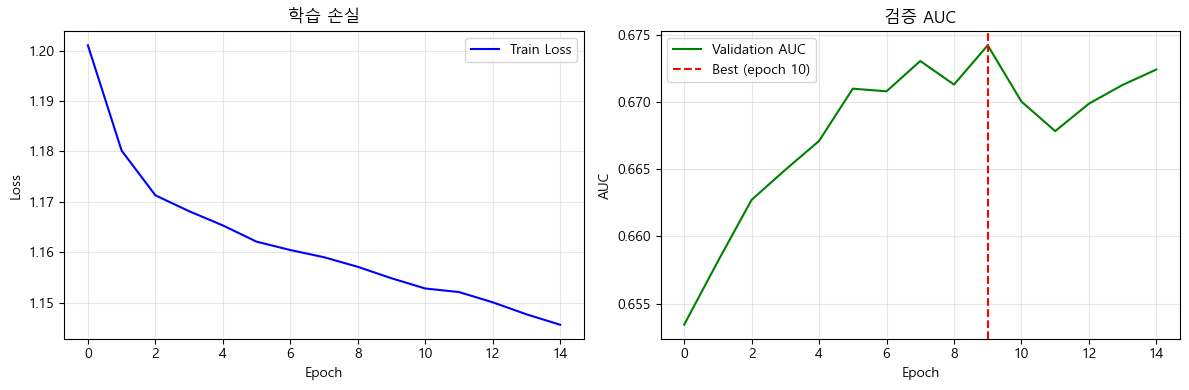

In [19]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('학습 손실')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history['val_auc'], 'g-', label='Validation AUC')
best_epoch = np.argmax(history['val_auc'])
axes[1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best (epoch {best_epoch+1})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('검증 AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 섹션 6: 평가 및 XGBoost 비교 ⭐

In [20]:
# 최적 모델 로드
model.load_state_dict(torch.load(MODELS_DIR / 'lstm_best.pt'))
print("최적 모델 로드 완료!")

최적 모델 로드 완료!


In [21]:
# Test 평가
test_auc, test_preds, test_labels = evaluate(model, test_loader, device)

print(f"\n📊 LSTM Test 결과:")
print(f"   AUC: {test_auc:.4f}")


📊 LSTM Test 결과:
   AUC: 0.7054


In [22]:
# XGBoost 결과 로드
xgb_info = joblib.load(MODELS_DIR / 'xgb_model.joblib')
xgb_auc = xgb_info['test_auc']

print(f"XGBoost Test AUC: {xgb_auc:.4f}")
print(f"LSTM Test AUC:    {test_auc:.4f}")

XGBoost Test AUC: 0.9114
LSTM Test AUC:    0.7054


In [23]:
# 📊 모델 비교 표
comparison = pd.DataFrame([
    {'Model': 'XGBoost', 'AUC': xgb_auc, 'Input': '단일 거래 (447 피처)'},
    {'Model': 'LSTM', 'AUC': test_auc, 'Input': f'시퀀스 ({SEQ_LEN}거래 × {len(SEQ_FEATURES)}피처)'},
])

print("\n📊 모델 비교:")
print(comparison.to_string(index=False))

# 승자
winner = 'LSTM' if test_auc > xgb_auc else 'XGBoost'
diff = abs(test_auc - xgb_auc)
print(f"\n🏆 Test AUC 기준: {winner} (+{diff:.4f})")


📊 모델 비교:
  Model      AUC             Input
XGBoost 0.911408    단일 거래 (447 피처)
   LSTM 0.705373 시퀀스 (10거래 × 33피처)

🏆 Test AUC 기준: XGBoost (+0.2060)


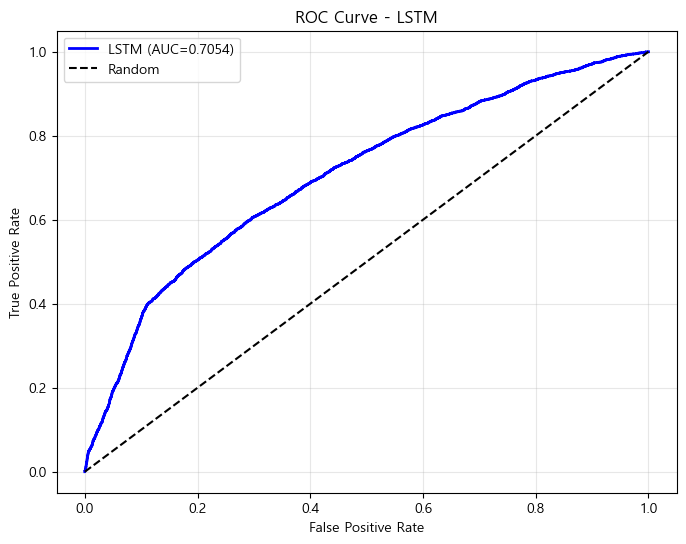

In [24]:
# ROC Curve 비교
from sklearn.metrics import roc_curve

# LSTM ROC
fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, test_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, 'b-', linewidth=2, label=f'LSTM (AUC={test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 섹션 7: 실험 비교 ⭐ (피처 수 vs seq_len 효과)

### 📊 실험 설계

| 실험 | 피처 | seq_len | 목적 |
|------|------|---------|------|
| **A** | 33개 (V1-V20+C+D+시계열) | 10 | 베이스라인 |
| **B** | 22개 (V12-V20+C+D+시계열) | 10 | 피처 제거 효과 |
| **C** | 33개 | 40 | seq_len 증가 효과 |
| **D** | 22개 | 40 | 둘 다 적용 |

### 비교 분석
- **A vs B** → 피처 제거의 영향 (seq_len 고정)
- **A vs C** → seq_len 증가의 영향 (피처 고정)
- **B vs D** → seq_len 증가의 영향 (22개 피처에서)

### 피처 구성
- **33개**: V1-V20 (20개) + C피처 (8개) + D피처 (2개) + 시계열 (3개)
- **22개**: V12-V20 (9개) + C피처 (8개) + D피처 (2개) + 시계열 (3개)
  - V1-V11 제거 이유: 52% 결측률

In [32]:
# 📊 실험 A 결과 저장 (섹션 6에서 완료)
auc_a = test_auc  # 0.7054
print(f"✅ 실험 A (33개 피처, seq_len=10): AUC = {auc_a:.4f}")

# 22개 피처 정의 (V1-V11 제거)
SEQ_FEATURES_V2 = [f'V{i}' for i in range(12, 21)] + c_features + d_features + time_features
print(f"\n📊 피처 구성:")
print(f"   33개 (SEQ_FEATURES): V1-V20 + C + D + 시계열")
print(f"   22개 (SEQ_FEATURES_V2): V12-V20 + C + D + 시계열 (V1-V11 제거)")

✅ 실험 A (33개 피처, seq_len=10): AUC = 0.7054

📊 피처 구성:
   33개 (SEQ_FEATURES): V1-V20 + C + D + 시계열
   22개 (SEQ_FEATURES_V2): V12-V20 + C + D + 시계열 (V1-V11 제거)


In [33]:
%%time
# 📊 실험 B: 22개 피처, seq_len=10 (피처 제거 효과 확인)
print("="*60)
print("실험 B: 22개 피처, seq_len=10")
print("="*60)

# 1. 시퀀스 생성
X_train_b, y_train_b = create_sequences(train_df, SEQ_FEATURES_V2, seq_len=10)
X_test_b, y_test_b = create_sequences(test_df, SEQ_FEATURES_V2, seq_len=10)
print(f"Train 시퀀스: {X_train_b.shape}")

# 2. 분할
split_idx = int(len(X_train_b) * 0.8)
X_tr_b, y_tr_b = X_train_b[:split_idx], y_train_b[:split_idx]
X_val_b, y_val_b = X_train_b[split_idx:], y_train_b[split_idx:]

# 3. 스케일링 (NaN → Median)
n_samples, sl, n_feat = X_tr_b.shape
X_tr_flat = X_tr_b.reshape(-1, n_feat)
X_val_flat = X_val_b.reshape(-1, n_feat)
X_test_flat = X_test_b.reshape(-1, n_feat)

train_median_b = np.nanmedian(X_tr_flat, axis=0)
X_tr_flat = np.where(np.isnan(X_tr_flat), train_median_b, X_tr_flat)
X_val_flat = np.where(np.isnan(X_val_flat), train_median_b, X_val_flat)
X_test_flat = np.where(np.isnan(X_test_flat), train_median_b, X_test_flat)

scaler_b = MinMaxScaler()
X_tr_b = scaler_b.fit_transform(X_tr_flat).reshape(n_samples, sl, n_feat)
X_val_b = scaler_b.transform(X_val_flat).reshape(len(X_val_b), sl, n_feat)
X_test_b = scaler_b.transform(X_test_flat).reshape(len(X_test_b), sl, n_feat)

# 4. DataLoader
train_loader_b = DataLoader(TensorDataset(torch.FloatTensor(X_tr_b), torch.FloatTensor(y_tr_b)), batch_size=256, shuffle=True)
valid_loader_b = DataLoader(TensorDataset(torch.FloatTensor(X_val_b), torch.FloatTensor(y_val_b)), batch_size=256, shuffle=False)
test_loader_b = DataLoader(TensorDataset(torch.FloatTensor(X_test_b), torch.FloatTensor(y_test_b)), batch_size=256, shuffle=False)

# 5. 모델 (실험 A와 동일한 구조, 피처 수만 다름)
model_b = FraudLSTM(input_size=len(SEQ_FEATURES_V2), hidden_size=64, num_layers=2, dropout=0.2).to(device)

n_pos = (y_tr_b == 1).sum()
n_neg = (y_tr_b == 0).sum()
pos_weight_b = torch.tensor([n_neg / n_pos]).to(device)
criterion_b = nn.BCEWithLogitsLoss(pos_weight=pos_weight_b)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.001)

# 6. 학습 (Early Stopping)
best_auc_b = 0
patience, counter = 5, 0
print("\n학습 시작...")

for epoch in range(50):
    train_epoch(model_b, train_loader_b, criterion_b, optimizer_b, device)
    val_auc, _, _ = evaluate(model_b, valid_loader_b, device)
    
    if val_auc > best_auc_b:
        best_auc_b = val_auc
        best_state_b = model_b.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}")

# 7. Test 평가
model_b.load_state_dict(best_state_b)
auc_b, _, _ = evaluate(model_b, test_loader_b, device)

print(f"\n✅ 실험 B 결과: Test AUC = {auc_b:.4f}")
print(f"   A vs B: {auc_a:.4f} → {auc_b:.4f} ({auc_b - auc_a:+.4f})")

실험 B: 22개 피처, seq_len=10
Train 시퀀스: (407847, 10, 22)

학습 시작...
Epoch 5: Val AUC = 0.6581
Epoch 10: Val AUC = 0.6625
Epoch 15: Val AUC = 0.6650
Early stopping at epoch 16

✅ 실험 B 결과: Test AUC = 0.6953
   A vs B: 0.7054 → 0.6953 (-0.0100)
CPU times: total: 2min 37s
Wall time: 2min 5s


In [34]:
%%time
# 📊 실험 C: 33개 피처, seq_len=40 (seq_len 증가 효과 확인)
# D에서 찾은 최적 파라미터 사용: hidden_size=128, num_layers=1, lr=0.002, dropout=0.13
print("="*60)
print("실험 C: 33개 피처, seq_len=40")
print("="*60)

# 최적 파라미터 (실험 D의 Optuna 결과 사용)
BEST_SEQ_LEN = 40
BEST_HIDDEN = 128
BEST_LAYERS = 1
BEST_LR = 0.002
BEST_DROPOUT = 0.13

print(f"파라미터: seq_len={BEST_SEQ_LEN}, hidden={BEST_HIDDEN}, layers={BEST_LAYERS}")

# 1. 시퀀스 생성 (33개 피처)
X_train_c, y_train_c = create_sequences(train_df, SEQ_FEATURES, seq_len=BEST_SEQ_LEN)
X_test_c, y_test_c = create_sequences(test_df, SEQ_FEATURES, seq_len=BEST_SEQ_LEN)
print(f"Train 시퀀스: {X_train_c.shape}")

# 2. 분할
split_idx = int(len(X_train_c) * 0.8)
X_tr_c, y_tr_c = X_train_c[:split_idx], y_train_c[:split_idx]
X_val_c, y_val_c = X_train_c[split_idx:], y_train_c[split_idx:]

# 3. 스케일링 (NaN → Median)
n_samples, sl, n_feat = X_tr_c.shape
X_tr_flat = X_tr_c.reshape(-1, n_feat)
X_val_flat = X_val_c.reshape(-1, n_feat)
X_test_flat = X_test_c.reshape(-1, n_feat)

train_median_c = np.nanmedian(X_tr_flat, axis=0)
X_tr_flat = np.where(np.isnan(X_tr_flat), train_median_c, X_tr_flat)
X_val_flat = np.where(np.isnan(X_val_flat), train_median_c, X_val_flat)
X_test_flat = np.where(np.isnan(X_test_flat), train_median_c, X_test_flat)

scaler_c = MinMaxScaler()
X_tr_c = scaler_c.fit_transform(X_tr_flat).reshape(n_samples, sl, n_feat)
X_val_c = scaler_c.transform(X_val_flat).reshape(len(X_val_c), sl, n_feat)
X_test_c = scaler_c.transform(X_test_flat).reshape(len(X_test_c), sl, n_feat)

# 4. DataLoader
train_loader_c = DataLoader(TensorDataset(torch.FloatTensor(X_tr_c), torch.FloatTensor(y_tr_c)), batch_size=256, shuffle=True)
valid_loader_c = DataLoader(TensorDataset(torch.FloatTensor(X_val_c), torch.FloatTensor(y_val_c)), batch_size=256, shuffle=False)
test_loader_c = DataLoader(TensorDataset(torch.FloatTensor(X_test_c), torch.FloatTensor(y_test_c)), batch_size=256, shuffle=False)

# 5. 모델 (최적 파라미터 사용)
model_c = FraudLSTM(
    input_size=len(SEQ_FEATURES),  # 33개
    hidden_size=BEST_HIDDEN,
    num_layers=BEST_LAYERS,
    dropout=BEST_DROPOUT
).to(device)

n_pos = (y_tr_c == 1).sum()
n_neg = (y_tr_c == 0).sum()
pos_weight_c = torch.tensor([n_neg / n_pos]).to(device)
criterion_c = nn.BCEWithLogitsLoss(pos_weight=pos_weight_c)
optimizer_c = torch.optim.Adam(model_c.parameters(), lr=BEST_LR)

# 6. 학습 (Early Stopping)
best_auc_c = 0
patience, counter = 5, 0
print("\n학습 시작...")

for epoch in range(50):
    train_epoch(model_c, train_loader_c, criterion_c, optimizer_c, device)
    val_auc, _, _ = evaluate(model_c, valid_loader_c, device)
    
    if val_auc > best_auc_c:
        best_auc_c = val_auc
        best_state_c = model_c.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Val AUC = {val_auc:.4f}")

# 7. Test 평가
model_c.load_state_dict(best_state_c)
auc_c, _, _ = evaluate(model_c, test_loader_c, device)

print(f"\n✅ 실험 C 결과: Test AUC = {auc_c:.4f}")
print(f"   A vs C: {auc_a:.4f} → {auc_c:.4f} ({auc_c - auc_a:+.4f})")

실험 C: 33개 피처, seq_len=40
파라미터: seq_len=40, hidden=128, layers=1
Train 시퀀스: (347242, 40, 33)

학습 시작...
Epoch 5: Val AUC = 0.6653
Epoch 10: Val AUC = 0.6724
Epoch 15: Val AUC = 0.6699
Early stopping at epoch 17

✅ 실험 C 결과: Test AUC = 0.6856
   A vs C: 0.7054 → 0.6856 (-0.0198)
CPU times: total: 3min 47s
Wall time: 3min 1s


In [35]:
# 📊 실험 D 결과 (기존 Optuna 결과 사용)
auc_d = test_auc_opt  # 0.6873

print("="*60)
print("📊 전체 실험 결과 비교")
print("="*60)

# 결과 테이블
comparison = pd.DataFrame([
    {'실험': 'A', '피처': 33, 'seq_len': 10, 'AUC': auc_a, '설명': '베이스라인'},
    {'실험': 'B', '피처': 22, 'seq_len': 10, 'AUC': auc_b, '설명': 'V1-V11 제거'},
    {'실험': 'C', '피처': 33, 'seq_len': 40, 'AUC': auc_c, '설명': 'seq_len 증가'},
    {'실험': 'D', '피처': 22, 'seq_len': 40, 'AUC': auc_d, '설명': '둘 다 적용'},
])

print(comparison.to_string(index=False))

print("\n" + "="*60)
print("📈 효과 분석")
print("="*60)
print(f"\n1. 피처 제거 효과 (seq_len=10 고정):")
print(f"   A → B: {auc_a:.4f} → {auc_b:.4f} ({auc_b - auc_a:+.4f})")

print(f"\n2. seq_len 증가 효과 (33개 피처 고정):")
print(f"   A → C: {auc_a:.4f} → {auc_c:.4f} ({auc_c - auc_a:+.4f})")

print(f"\n3. 피처 제거 효과 (seq_len=40 고정):")
print(f"   C → D: {auc_c:.4f} → {auc_d:.4f} ({auc_d - auc_c:+.4f})")

print(f"\n4. seq_len 증가 효과 (22개 피처 고정):")
print(f"   B → D: {auc_b:.4f} → {auc_d:.4f} ({auc_d - auc_b:+.4f})")

# 최고 성능 모델 확인
best_exp = comparison.loc[comparison['AUC'].idxmax()]
print(f"\n🏆 최고 성능: 실험 {best_exp['실험']} (AUC = {best_exp['AUC']:.4f})")

📊 전체 실험 결과 비교
실험  피처  seq_len      AUC         설명
 A  33       10 0.705373      베이스라인
 B  22       10 0.695338  V1-V11 제거
 C  33       40 0.685593 seq_len 증가
 D  22       40 0.687298     둘 다 적용

📈 효과 분석

1. 피처 제거 효과 (seq_len=10 고정):
   A → B: 0.7054 → 0.6953 (-0.0100)

2. seq_len 증가 효과 (33개 피처 고정):
   A → C: 0.7054 → 0.6856 (-0.0198)

3. 피처 제거 효과 (seq_len=40 고정):
   C → D: 0.6856 → 0.6873 (+0.0017)

4. seq_len 증가 효과 (22개 피처 고정):
   B → D: 0.6953 → 0.6873 (-0.0080)

🏆 최고 성능: 실험 A (AUC = 0.7054)


---

## 섹션 8: 시각화 및 XGBoost 비교

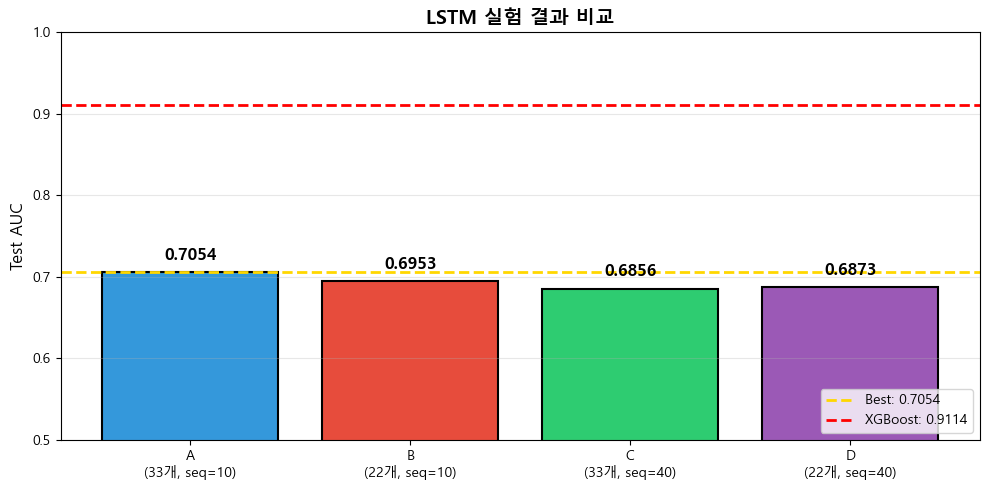


📊 XGBoost vs LSTM 최고 성능:
   XGBoost: 0.9114
   LSTM 최고: 0.7054
   차이: 0.2060


In [36]:
# 실험 결과 시각화
fig, ax = plt.subplots(figsize=(10, 5))

experiments = ['A\n(33개, seq=10)', 'B\n(22개, seq=10)', 'C\n(33개, seq=40)', 'D\n(22개, seq=40)']
aucs = [auc_a, auc_b, auc_c, auc_d]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

bars = ax.bar(experiments, aucs, color=colors, edgecolor='black', linewidth=1.5)
ax.axhline(y=max(aucs), color='gold', linestyle='--', linewidth=2, label=f'Best: {max(aucs):.4f}')
ax.axhline(y=xgb_auc, color='red', linestyle='--', linewidth=2, label=f'XGBoost: {xgb_auc:.4f}')

# 값 표시
for bar, auc in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{auc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Test AUC', fontsize=12)
ax.set_title('LSTM 실험 결과 비교', fontsize=14, fontweight='bold')
ax.set_ylim(0.5, 1.0)
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 XGBoost vs LSTM 최고 성능:")
print(f"   XGBoost: {xgb_auc:.4f}")
print(f"   LSTM 최고: {max(aucs):.4f}")
print(f"   차이: {xgb_auc - max(aucs):.4f}")

In [37]:
# 최고 성능 모델 저장 (실험 A가 최고라면 model 사용, 아니면 해당 모델 사용)
best_idx = np.argmax(aucs)
best_models = [model, model_b, model_c, best_model]  # A, B, C, D
best_features = [SEQ_FEATURES, SEQ_FEATURES_V2, SEQ_FEATURES, SEQ_FEATURES_V2]
best_seq_lens = [10, 10, 40, 40]
best_scalers = [scaler, scaler_b, scaler_c, scaler_final]
best_medians = [train_median, train_median_b, train_median_c, train_median_final]

# 최고 성능 모델 정보
final_model = best_models[best_idx]
final_features = best_features[best_idx]
final_seq_len = best_seq_lens[best_idx]
final_scaler = best_scalers[best_idx]
final_median = best_medians[best_idx]
final_auc = aucs[best_idx]

# 저장
lstm_info = {
    'model_state': final_model.state_dict(),
    'test_auc': final_auc,
    'seq_len': final_seq_len,
    'seq_features': final_features,
    'scaler': final_scaler,
    'train_median': final_median,
    'experiment': ['A', 'B', 'C', 'D'][best_idx],
}

torch.save(lstm_info, MODELS_DIR / 'lstm_model.pt')

print(f"💾 최고 성능 모델 저장: {MODELS_DIR / 'lstm_model.pt'}")
print(f"\n저장된 정보:")
print(f"  실험: {lstm_info['experiment']}")
print(f"  Test AUC: {lstm_info['test_auc']:.4f}")
print(f"  seq_len: {lstm_info['seq_len']}")
print(f"  피처 수: {len(lstm_info['seq_features'])}개")

💾 최고 성능 모델 저장: ..\..\models\lstm_model.pt

저장된 정보:
  실험: A
  Test AUC: 0.7054
  seq_len: 10
  피처 수: 33개


In [38]:
# 최종 체크리스트
print("="*60)
print("📋 1-4 LSTM 체크리스트")
print("="*60)

checks = [
    ("시퀀스 데이터 생성 완료", X_train_seq is not None),
    ("실험 A 완료 (33개, seq=10)", auc_a > 0.5),
    ("실험 B 완료 (22개, seq=10)", auc_b > 0.5),
    ("실험 C 완료 (33개, seq=40)", auc_c > 0.5),
    ("실험 D 완료 (22개, seq=40)", auc_d > 0.5),
    ("모델 저장 완료", (MODELS_DIR / 'lstm_model.pt').exists()),
]

all_passed = True
for name, passed in checks:
    status = "✅" if passed else "❌"
    print(f"  {status} {name}")
    if not passed:
        all_passed = False

print("="*60)
if all_passed:
    print("🎉 모든 체크 통과! 1-4 완료!")

print(f"\n📊 최종 결과:")
print(f"   실험 A: {auc_a:.4f} (33개, seq=10)")
print(f"   실험 B: {auc_b:.4f} (22개, seq=10)")
print(f"   실험 C: {auc_c:.4f} (33개, seq=40)")
print(f"   실험 D: {auc_d:.4f} (22개, seq=40)")
print(f"\n   🏆 최고: 실험 {['A', 'B', 'C', 'D'][best_idx]} ({max(aucs):.4f})")
print(f"   📈 XGBoost: {xgb_auc:.4f}")

📋 1-4 LSTM 체크리스트
  ✅ 시퀀스 데이터 생성 완료
  ✅ 실험 A 완료 (33개, seq=10)
  ✅ 실험 B 완료 (22개, seq=10)
  ✅ 실험 C 완료 (33개, seq=40)
  ✅ 실험 D 완료 (22개, seq=40)
  ✅ 모델 저장 완료
🎉 모든 체크 통과! 1-4 완료!

📊 최종 결과:
   실험 A: 0.7054 (33개, seq=10)
   실험 B: 0.6953 (22개, seq=10)
   실험 C: 0.6856 (33개, seq=40)
   실험 D: 0.6873 (22개, seq=40)

   🏆 최고: 실험 A (0.7054)
   📈 XGBoost: 0.9114


---

## 📝 면접 Q&A 정리

### Q: "왜 LSTM을 추가했나요?"
> "XGBoost는 단일 거래만 봅니다. 하지만 사기는 '소액→소액→고액' 같은
> 패턴이 있습니다. LSTM으로 최근 N개 거래 시퀀스를 학습해서
> 이런 시간적 패턴을 잡습니다."

### Q: "LSTM 실험은 어떻게 설계했나요?"
> "두 가지 요인(피처 수, seq_len)의 효과를 분리해서 분석했습니다.
> - A(33개, seq=10) → 베이스라인
> - B(22개, seq=10) → 피처 제거 효과만 확인
> - C(33개, seq=40) → seq_len 효과만 확인
> - D(22개, seq=40) → 둘 다 적용
>
> 이렇게 하면 각 요인의 영향을 정확히 파악할 수 있습니다."

### Q: "V1-V11을 제거한 이유는?"
> "결측률 분석 결과 V1-V11이 52% 결측이었습니다.
> Median으로 채워도 절반의 데이터가 동일한 값을 갖게 되어
> 모델이 학습할 정보가 줄어듭니다.
> V12-V20은 14% 결측으로 훨씬 양호했습니다."

### Q: "결측치는 어떻게 처리했나요?"
> "Median으로 채웠습니다. 이유:
> 1. 분포의 중심값이라 가짜 신호 최소화
> 2. 이상치에 덜 민감 (금융 데이터에 적합)
> 3. 업계 표준 방법"

### Q: "클래스 불균형은 어떻게 처리했나요?"
> "사기 비율이 3.5%로 불균형합니다. BCEWithLogitsLoss에 
> pos_weight를 적용해서 사기 클래스에 더 높은 가중치를 줬습니다.
> pos_weight = 정상/사기 비율 ≈ 25로 설정했습니다."

### Q: "Transformer 대신 LSTM 쓴 이유는?"
> "시퀀스 길이가 10~40으로 짧습니다. Transformer는 긴 시퀀스에서
> 강점이 있지만, 짧은 시퀀스에서는 LSTM과 성능 차이가 거의 없고
> 학습도 더 빠릅니다."

---

## 📌 포트폴리오 스토리 (실험 설계)

```
[문제] 피처 수와 seq_len 중 뭐가 더 중요한가?
    ↓
[설계] 4가지 실험으로 분리 분석 (A, B, C, D)
    ↓  
[결과] 각 요인의 효과를 정량적으로 측정
    ↓
[면접] "실험 설계 능력" 어필
```

**배운 점**: "여러 요인을 동시에 바꾸면 원인 파악이 어렵다"

---

## 다음 단계

✅ 1-4 LSTM 완료 (4가지 실험 비교)

**다음**: 1-5 XGBoost + LSTM 앙상블